version 1.1 ~ GMcK

# Fraud Detection

An important application of Data Science within the Fintech "Financial Technology" industry is detecting fraudulent transactions. In this notebook we train a model to predict which transaction might be fraudulent.
<img src="../images/fraud.jpg" alt="Fraud" style="width: 800px; align:center;"/>

## The dataset

The dataset contains the following columns:

* merchant: The id of our client
*  first_6_digit: The first 6 digit of the credit card used in the transaction
* payment_ref: The unique reference for this payment
* amount_eur: The amount in euros
* card_network: The network that emitted the card
* card_type: The type of card
* timestamp: The timestamp when the payment was received
* refused_by_bank: A payment can also be refused by the bank for various reasons (lack of funds, card lost etc..)
* bank_country_id: The country of the bank
* user_id: The id of the user that is performing the payment
* user_country_id: The country of the user that is performing the payment
* is_fraud: Whether the payment was flagged as fraudulent.

## Machine Learning Steps

* Read in file from name, clean the data & create some derived variables
* Explore relationships between target and features
* Create a Baseline Model off which to benchmark performance
* Select, tune and assess final classificaton model


## Notebook Structure

The Notebook is structured in the following way:

 * Setup (requirements for running the following analysis & code)
 * Data Loading & Preparation & Feature Engineering
 * Exploratory Data Analysis
 * Model Development & Performance




# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
plt.style.use('ggplot')

## sklearn
Scikit-learn is a free machine learning library for Python. It features various algorithms like support vector machine, random forests, and k-neighbours, and it also supports Python numerical and scientific libraries like NumPy and SciPy

In [ ]:
! pip install seaborn # Graphics
! pip install sklearn # Machine Learning

# Data Preparation

In [3]:
df = pd.read_csv('../data/fraud_data.csv', index_col=[0])

In [4]:
df.columns

Index(['merchant', 'first_6_digits', 'payment_ref', 'amount_eur',
       'card_network', 'card_type', 'timestamp', 'refused_by_bank',
       'bank_country_id', 'user_id', 'user_country_id', 'is_fraud'],
      dtype='object')

In [5]:
df.shape

(43220, 12)

In [6]:
df.head()

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,refused_by_bank,bank_country_id,user_id,user_country_id,is_fraud
0,Shop8,96543.0,78089c3946037ca9,0.00,SchemeF,DEBIT,1458169972,0,0.0,2.673933e+09,0.0,0
1,Shop8,579100.0,62c49a618760d829,0.00,SchemeD,DEBIT,1458401237,0,1.0,2.684546e+09,1.0,0
2,Shop2,535041.0,75517f4497a164e1,6.00,SchemeF,CREDIT,1458509094,0,2.0,2.238808e+09,2.0,0
3,Shop2,314986.0,aeecc3a05e7f472c,23.38,SchemeB,DEBIT,1460494815,0,6.0,2.104261e+09,3.0,0
4,Shop2,893427.0,3de199afd69c4f31,64.00,SchemeI,CREDIT,1460444513,0,6.0,1.188328e+09,3.0,0


In [7]:
df['first_6_digits']= df['first_6_digits'].astype(str)

In [8]:
df.dtypes

merchant            object
first_6_digits      object
payment_ref         object
amount_eur         float64
card_network        object
card_type           object
timestamp            int64
refused_by_bank      int64
bank_country_id    float64
user_id            float64
user_country_id    float64
is_fraud             int64
dtype: object

## Test yourself!!

* Look at 5 rows of the dataframe where is_fraud==1
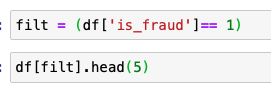

In [ ]:
# Answer


## Time Features

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [10]:
df['dow_txn'] = df['timestamp'].apply(lambda x:x.dayofweek)


In [11]:
df['hour_txn'] = df['timestamp'].apply(lambda x:x.hour)

## Test yourself!!

* Create a new feature "month_txn" which is a column in the df which is the number of the month of the transaction

Hint:
See Above

In [12]:
# Answer to 3.3


## Data Quality

### Duplication

In [13]:
# check for duplicates
any(df.duplicated())

True

In [14]:
any(df.duplicated('payment_ref'))

True

In [15]:
df[df['payment_ref'].isin(list(df[df.duplicated('payment_ref')]['payment_ref']))]

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,refused_by_bank,bank_country_id,user_id,user_country_id,is_fraud,dow_txn,hour_txn
10292,Shop2,370986.0,d06a71204d2cfa4d,27.13,SchemeB,NaN,2016-03-31 01:11:44,0,6.0,2.362693e+09,6.0,0,3,1
10293,Shop2,370986.0,d06a71204d2cfa4d,27.13,SchemeB,NaN,2016-03-31 01:11:44,0,6.0,2.362693e+09,6.0,0,3,1


In [16]:
# removal
df = df[~df['payment_ref'].isin(list(df[df.duplicated('payment_ref')]['payment_ref']))]

In [17]:
df.shape

(43218, 14)

## Test yourself!!
* Check whether there are users that have made the same payments repeatedly. <br>
use a filt: **df.duplicated(['one','two')]** and then the method value_counts(), and apply 'filt'

In [18]:
filt = df.duplicated(['amount_eur', 'user_id'])

### Missing Data

<AxesSubplot:>

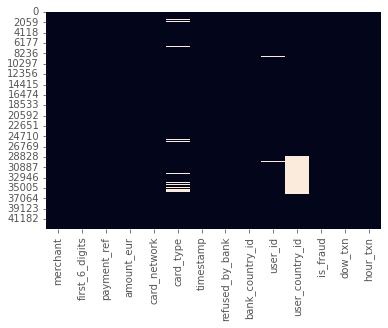

In [19]:
plt.rcParams['figure.figsize']=(15,10)
sns.heatmap(df.isnull(), cbar=False)

In [20]:
df.isnull().sum()

merchant              0
first_6_digits        0
payment_ref           0
amount_eur            0
card_network          4
card_type          2505
timestamp             0
refused_by_bank       0
bank_country_id     130
user_id             430
user_country_id    7482
is_fraud              0
dow_txn               0
hour_txn              0
dtype: int64

## Analysis of Missing Data
There exist missing data for a number of the variables present in this data-set. Treatment of each is outlined below. With more time more sophisticated methods (e.g. impute missing user_country_id from bank_country_id, merchant etc.) should be considered and sensitivity to missing data assessed. Here I have taken the approach of keeping information about 'missingness' (in case it is predictive of fraud) where sensible at the cost of losing information possible inferrable from imputing these values. Omitting these records completely would only be warranted if we were sure the missing data mechanism was MCAR (missing completely at random) and the the "good" records were representative of those missing (but at a minimum you could imagine the missingness of Card Network being assoicated with merchant?)

* first_6_digits: it is very suspicious that these these are missing - it is hard to thing of a non data corruption reason for this but nevertheless will encode as 'missing'
* card_network: again this seems more like a data corruption/processing issue but nevertheless will encode as 'missing'
* card_type: encoded as 'missing' - this could be legitimately not available for some card types?
* bank_country_id: encoded as 'missing' - this could be legitimately not available for some banks
* user_id: encoded as 'missing' - this again seems to be unlikely to be not available
* user_country_id: encoded as 'missing' - this could be legitimately not available for some users although the pattern observed in the above heatmap warrants some further investigation.)



In [21]:
df.fillna('missing', inplace=True)

One hypothesis could being seeing the patern above that if the dataset was ordered by time payment recieved then perhaps the country ids were missing for a particular time period but looking at the below that does not seem to be the case. A fuller investigation would check whether the df is ordered by any other of the features (doesn't appear to be) and also consider the cross tabulation of user country id missingness with other cat features.


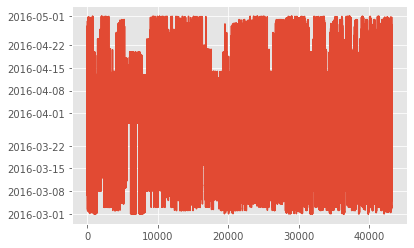

In [22]:
plt.plot(df.index, df.timestamp)

## Test yourself!!

* You are suspicious of the missing data in the first_six_digits column and so instead of replacing those values you drop all the rows in the dataframe for which this column is missing a value. Hint: df.dropna(subset= ['one'])

In [ ]:
# Put your answer here

#  Exploratory Data Analysis

## Target Variable

In [23]:
df['is_fraud'].value_counts()


0    42994
1      224
Name: is_fraud, dtype: int64

In [24]:
df.groupby(['is_fraud'])['payment_ref'].count()

is_fraud
0    42994
1      224
Name: payment_ref, dtype: int64

<BarContainer object of 2 artists>

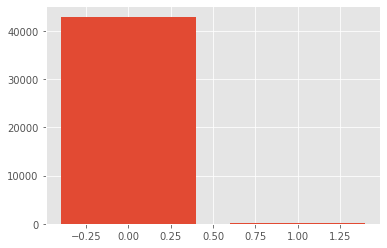

In [25]:
plt.bar(df.groupby(['is_fraud'])['payment_ref'].count().index, df.groupby(['is_fraud'])['payment_ref'].count())

## Test yourself!

* Add a title and labels for x and y axis to the above plot.
hint:
plt.title('x')
plt.xlabel('y')
plt.ylabel('z')

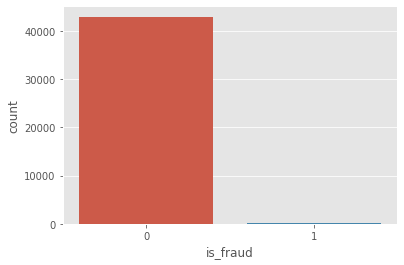

In [26]:
ax = sns.countplot(x="is_fraud", data=df)

## First 6 Digits of the Card

In [27]:
pd.crosstab(df['merchant'], df['is_fraud']).apply(lambda r: round(r/r.sum(), 3),axis = 1)


is_fraud,0,1
merchant,,
Shop1,0.970,0.030
Shop2,0.993,0.007
Shop3,0.999,0.001
Shop4,1.000,0.000
Shop5,0.998,0.002
Shop6,1.000,0.000
Shop7,1.000,0.000
Shop8,1.000,0.000


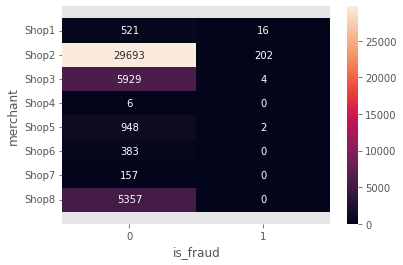

In [28]:
ax = sns.heatmap(pd.crosstab(df['merchant'], df['is_fraud']), annot = True, fmt=".0f")
ax = ax.set_ylim(len(pd.crosstab(df['merchant'], df['is_fraud']))+ 0.5, -0.5)

In [29]:
df['first_6_digits'].value_counts()[0:20]

934471.0    1381
740079.0    1299
303700.0    1079
625175.0     982
805203.0     930
126429.0     900
429753.0     846
497671.0     841
975044.0     680
98184.0      608
989699.0     605
759248.0     553
640891.0     548
196048.0     544
267236.0     471
235481.0     470
658736.0     462
510455.0     454
293420.0     438
843655.0     434
Name: first_6_digits, dtype: int64

Lets look at the top twenty of these and see if there appears to be any glaring relation to fraud.

In [30]:
temp = df[df.first_6_digits.isin(df['first_6_digits'].value_counts()[0:20].index.to_list())]
pd.crosstab(temp['first_6_digits'], temp['is_fraud']).apply(lambda r: round(r/r.sum(), 3),axis = 1)


is_fraud,0,1
first_6_digits,,
126429.0,0.991,0.009
196048.0,0.993,0.007
235481.0,1.000,0.000
267236.0,1.000,0.000
293420.0,1.000,0.000
303700.0,0.990,0.010
429753.0,0.998,0.002
497671.0,1.000,0.000
510455.0,0.996,0.004


There is no major pattern immediately discernible and such a highly cardinal variable is difficult to include in the model. In future developments it may make sense to look at derived variables from these (e.g. issuing bank).

## Test yourself!!

* Using a pandas groupby (or some other way) - calculate the average amount spent in each merchant. <br>
df.groupby(['one'])['two'].mean()

In [ ]:
# Answer

## 3.3. Amount Euro



Currency amounts are typically highly skewed and this is what is exhibited in the dataset. In addition there are number of extreme values and transactions of amount 0.

* Most instituions have some limit on card transactions and so my supspicion is that the extreme values are not 'true outliers' but rather corrupted data and so I will exlude those 8 for which the amount is above 10,000 euro.
* 0 euro amount transactions may happen when a merchant is "validating" a card. These I have left in as I believe them to be non-corrupted although there are merchant patterns worthy of later investigation.
* I use a log transform of the amount eur to aid in visualisation & model training.



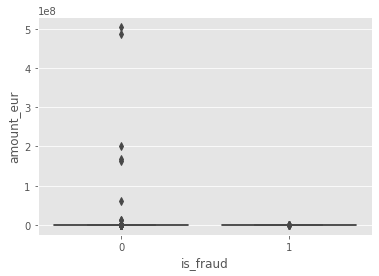

In [31]:
ax = sns.boxplot(x="is_fraud", y="amount_eur",data=df)

There appears to be nothing else strange about these extreme values, and no obvious pattern.

In [32]:
df.nlargest(5, "amount_eur", keep='first')

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,refused_by_bank,bank_country_id,user_id,user_country_id,is_fraud,dow_txn,hour_txn
35531,Shop2,303700.0,bbc7dc55d597ef53,503700480.0,SchemeB,DEBIT,2016-03-16 05:34:07,0,6.0,1037640899.0,missing,0,2,5
34257,Shop2,445070.0,eb891582143f8e39,487527744.0,SchemeI,CREDIT,2016-03-10 08:41:36,0,6.0,693391921.0,missing,0,3,8
33395,Shop2,448164.0,58dbf4c1cc5430f7,201850560.0,SchemeD,DEBIT,2016-04-08 18:47:43,0,6.0,847150455.0,missing,0,4,18
24397,Shop2,194687.0,7a37b7bf9bb20591,167282880.0,SchemeB,missing,2016-04-07 09:14:27,0,6.0,1329984662.0,6.0,0,3,9
30875,Shop1,429753.0,7204da05b1a429ad,162961920.0,SchemeB,DEBIT,2016-03-24 01:04:34,1,6.0,1482686646.0,missing,0,3,1


In [34]:
df = df[df["amount_eur"]< 10000]

Again these look legitimate except that they largely seem to come from 'Shop8' and none are Fraudulent. Perhaps Shop 8 is some sort of (e.g. App) where there is a possibilty to upgrade (for a very low amount e.g. 1 euro) and a card must be provided for sign-up? Anyways I have left them in for the time being - this with more time should be investigate however.

In [35]:
df[df["amount_eur"]== 0]['merchant'].value_counts()

Shop8    5215
Shop2      52
Shop7      16
Name: merchant, dtype: int64

In [36]:
df[df['merchant']== 'Shop8']['amount_eur'].value_counts()


0.0000    5215
2.0000     133
1.0000       8
1.1559       1
Name: amount_eur, dtype: int64

In [37]:
df[df["amount_eur"]== 0]['is_fraud'].value_counts()

0    5283
Name: is_fraud, dtype: int64

In [38]:
df[df["amount_eur"]== 0].head(5)

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,refused_by_bank,bank_country_id,user_id,user_country_id,is_fraud,dow_txn,hour_txn
0,Shop8,96543.0,78089c3946037ca9,0.0,SchemeF,DEBIT,2016-03-16 23:12:52,0,0.0,2673932631.0,0.0,0,2,23
1,Shop8,579100.0,62c49a618760d829,0.0,SchemeD,DEBIT,2016-03-19 15:27:17,0,1.0,2684545860.0,1.0,0,5,15
13,Shop8,971958.0,465ccfa0157f1323,0.0,SchemeD,CREDIT,2016-03-28 23:37:03,0,10.0,2712571765.0,6.0,0,0,23
15,Shop8,876706.0,4b1fb4f472aacbaf,0.0,SchemeF,CREDIT,2016-03-08 19:27:03,0,10.0,942296006.0,6.0,0,1,19
28,Shop8,152988.0,693361875d5067b5,0.0,SchemeD,CREDIT,2016-03-14 22:16:28,0,10.0,2670617023.0,6.0,0,0,22


Looking at the overal distribution of amount in euro it is difficult to make any conclusions due to the skew in the data which we address below.

/Users/morgan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/morgan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='amount_eur', ylabel='Density'>

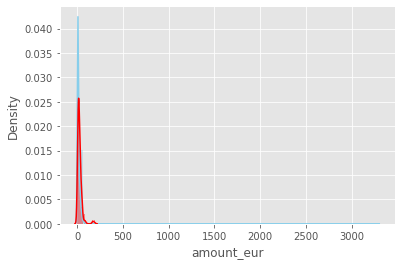

In [39]:

sns.distplot( df[df.is_fraud ==0]["amount_eur"], color="skyblue", label="Non Fraudulent")
sns.distplot( df[df.is_fraud ==1]["amount_eur"] , color="red", label="Fraudulent")

In [40]:
df[df['amount_eur']< 0]

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,refused_by_bank,bank_country_id,user_id,user_country_id,is_fraud,dow_txn,hour_txn


In [41]:
df['amount_eur'] =  pd.Series(np.log(df['amount_eur'] + 1))

/Users/morgan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/morgan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


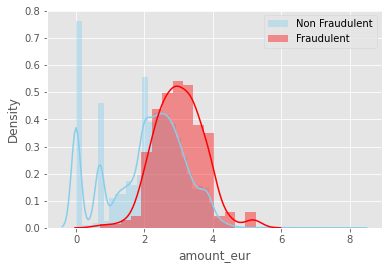

In [42]:
ax = sns.distplot( df[df.is_fraud ==0]["amount_eur"], color="skyblue", label="Non Fraudulent")
ax = sns.distplot( df[df.is_fraud ==1]["amount_eur"] , color="red", label="Fraudulent")
ax.legend()

## Test yourself! (For at Home)

* Try look at another of the features (e.g. user_country_id) using the above analysis as a template, (For at home) 

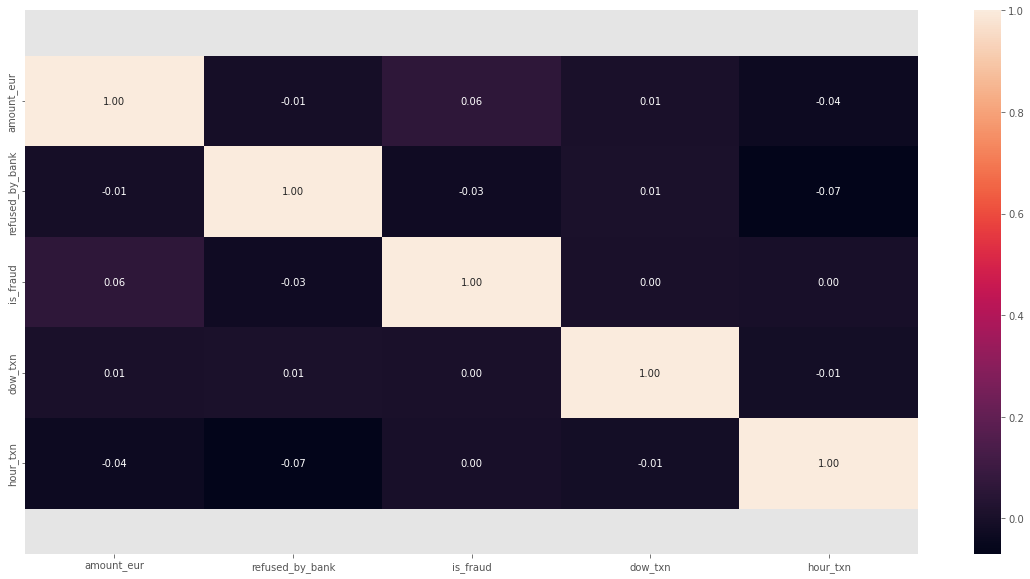

In [43]:
corr = df.corr()

plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, annot= True, fmt = '.2f')
ax = ax.set_ylim(len(corr)+ 0.5, -0.5)

#  Model Development & Performance

In [44]:
y = df["is_fraud"]

base_features = ['merchant', 'amount_eur', 'card_network']
dummy_features = ['merchant',  'card_network']

X= df[[c for c in df.columns if c in base_features]]

X = pd.get_dummies(X, columns=dummy_features)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Logistic Regression

In [46]:
lr = LogisticRegression()

In [47]:
lr.fit(X_train, y_train)


LogisticRegression()

In [48]:
y_pred = lr.predict(X_test)

## Test yourself!(~home)

* Try train a different model on your data -> have a look at Skicitlearn docs to see which may suit this prediction task! (Do not try this at home!)

## 4.2. Performance

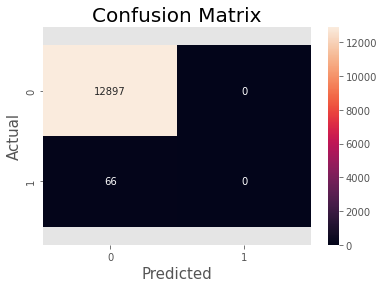

In [49]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot =True,  fmt = '.0f')
ax = ax.set_ylim(2+ 0.2, -0.2)
plt.title('Confusion Matrix', fontsize = 20) 
plt.xlabel('Predicted', fontsize = 15) 
plt.ylabel('Actual', fontsize = 15) 
plt.show()


In [50]:
test_df = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [51]:
test_df.head()

,amount_eur,merchant_Shop1,merchant_Shop2,merchant_Shop3,merchant_Shop4,merchant_Shop5,merchant_Shop6,merchant_Shop7,merchant_Shop8,card_network_SchemeB,...,card_network_SchemeDA,card_network_SchemeDB,card_network_SchemeF,card_network_SchemeFA,card_network_SchemeFB,card_network_SchemeG,card_network_SchemeH,card_network_SchemeI,card_network_SchemeIA,card_network_missing
0,2.085672,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3.433987,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.526056,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2.964242,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df['real_label'] = y_test
test_df['predicted_label'] = y_pred

In [ ]:
test_df

## Test yourself! (At Home)

* Calculate the Precision and Recall of your model  on the test set (test_df) - you can do this using sklearn.metrics or you can use pandas to calculate from scratch
* Precision = number correctly predicted fraud/ all predicted fraud
* Recall = number correctly predicted fraud/all truly fraud